Note: Using the optimal sigma value from the coarser mesh for each eigenvalue

Monolayer unit domain. Piecewise PML. Convergence (eigenvalue error)

In [228]:
# Importing libraries
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
    dx
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, create_submesh
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix, Expression, assemble_scalar
import basix
from petsc4py.PETSc import ScalarType, KSP
from slepc4py.SLEPc import EPS  
colors_list = ["blue", "green", "red", "magenta", "black", "purple", "orange", "brown", "pink"]


In [229]:
# dolfinx.__version__

Domain, PML, refinement and physical configurations

In [230]:
# Define element size for the mesh refinement
h_i = [ 0.0625, 
    0.0625 / 2,  #N=2
        0.0625 / 4,  #N=3
        0.0625 / 8,] #N=4


# Domain configuration
Lx = 1. # fluid domain length (without PML)
l_inner=Lx/2

# Physical configuration
rho_media_1 = 1. # kg/m^3 
vel_media_1 = 2.   # m/s
rho_media_2 = 1. # kg/m^3 
vel_media_2 = 1.   # m/s

# Define the density and velocity functions  
def rho_function(x):    
    return np.where(x[0] > l_inner, rho_media_2,rho_media_1)

def vel_function(x):    
    return np.where(x[0] > l_inner, vel_media_2,vel_media_1)
 
# PML configuration
pml_thickness = Lx/4

# Solver configuration

requested_eigenvalues_number = 50 # Number of eigenvalues to compute

In [231]:
def get_configured_problem(mesh, degrees, sigma_x, target):
    # Initialize dictionaries
    dof = {}
    solver_dict={}
    V_dict={}
    Q_dict={}

    # Define finite element spaces
    p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=degrees[0])
    v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=degrees[1], shape=(mesh.geometry.dim,))
    FE = {"p": p_fe_type, "v": v_fe_type}

    # Create a submesh of PML associated cells
    tdim = mesh.topology.dim

    # Create function spaces for mesh and submesh
    Q = functionspace(mesh,FE["p"])
    V = functionspace(mesh, FE["v"])

    # Dictionaries to store the number of dofs
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global

    # Boundary conditions application (for pressure)
    bc = []
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 
    
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 

    # Define differential operators
    dx = Measure("dx", domain=mesh)

    # Interpolates the density and velocity functions
    W = functionspace(mesh, ("DG", 2))
    rho = Function(W)
    rho.interpolate(rho_function)
    c = Function(W)
    c.interpolate(vel_function)

    # Spatial Coordinate is updated for the actual mesh
    x = SpatialCoordinate(mesh)

    # Variation formulation definition
    p = TrialFunction(Q) 
    v = TrialFunction(V)
    q = TestFunction(Q)
    w = TestFunction(V)

    # Define the variational forms
    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx, -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]  
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    # solver.setWhichEigenpairs(9)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )
    solver.setTolerances(1e-16, 1000)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert" 
    solver.setTarget(target)  #-12j  
    solver.solve()
    n_eigs_converged_piecewise = solver.getConverged()
    
    return solver, mesh, Q, V, dof, FE

In [232]:
def get_approx_eigenpair(solver, selected_index, Q, V, dof):
    # Gets p, v eigenvectors
    p_h = Function(Q, name="p")
    v_h = Function(V, name="v")
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global
    [vrA, viA] = solver.getOperators()[0].getVecs()  # type: ignore

    # Filtrar eigenvalores con parte real mayor que 1e-12
    eigenvalues = []
    for i in range(solver.getConverged()):
        omega_value = solver.getEigenpair(i, vrA) * (1j)  # type: ignore
        if omega_value.real > 1e-12:
            eigenvalues.append((omega_value, vrA.copy()))

    # Seleccionar el n-ésimo eigenvalor filtrado
    omega_value, vrA = eigenvalues[selected_index]

    # FEM approximation for the eigenfunction
    p_h.x.petsc_vec.array[:] = vrA[0 : dof["p"]]
    p_h.x.petsc_vec.array[:] = p_h.x.petsc_vec.array[:] / p_h.eval([Lx, 0.0, 0.0], 1)  # normalise
    v_h.x.petsc_vec.array[:] = vrA[dof["p"] :]  
    v_h.x.petsc_vec.array[:] = v_h.x.petsc_vec.array[:] / v_h.eval([Lx, 0.0, 0.0], 1)  # normalise

    return [omega_value, p_h, v_h]  # Return eigenfunction and eigenvalue

In [233]:
def get_exact_eigenpair(mesh, FE, selected_index, sigma_x, x_hat, gamma_x):
    exact_physical_eigs_function= lambda n: vel_media_1 / l_inner * np.arctan(-1j * (vel_media_2 * rho_media_2) / (vel_media_1 * rho_media_1))+ n * np.pi * vel_media_1 / l_inner
    w=exact_physical_eigs_function(selected_index)

    p_1 = lambda x: np.sin(w * x[0] / vel_media_1)
    p_2 = lambda x: -np.sin(-w * l_inner / vel_media_1) * np.exp(1j * w / vel_media_2 * (x_hat(x,w) - l_inner))
    p = lambda x: np.where(x[0] == Lx + pml_thickness, 0, np.where(x[0] >= l_inner, p_2(x), p_1(x)))

    sigma_x_function_cond= lambda x: np.where(x[0]<=Lx, x[0]*0., np.where(x[0] == Lx + pml_thickness, x[0]*0.0+1e10, sigma_x(x)))
    v_1=lambda x: 1/(-1j*w)*(w / vel_media_1) * np.cos(w * x[0] / vel_media_1)
    v_2 = (lambda x: 1/(-1j*w+sigma_x_function_cond(x)*rho_media_1)* -np.sin(-w * l_inner / vel_media_1) *(1j * w / vel_media_2)
        * np.exp(1j * w / vel_media_2 * (x_hat(x,w) - l_inner))* gamma_x(x, w)[0])
    # v = lambda x: np.where(x[0] >= l_inner, v_2(x), v_1(x))
    v = lambda x: np.where(x[0] >= l_inner, v_1(x), v_1(x))
    Q = functionspace(mesh, FE["p"])
    V = functionspace(mesh, FE["v"])

    p_ex = Function(Q, name="p_ex")
    p_ex.interpolate(p)
    p_ex.x.petsc_vec.array[:] = p_ex.x.petsc_vec.array[:] / p_ex.eval(np.array([Lx, 0.0, 0.0]), 1)

    v_ex = Function(V, name="v_ex")
    v_ex.interpolate(v)
    v_ex.x.petsc_vec.array[:] = v_ex.x.petsc_vec.array[:] / v_ex.eval(np.array([Lx, 0.0, 0.0]), 1)

    return [w, p_ex, v_ex]

In [234]:
target={0: -12j, 1: -50j}

In [235]:
def project_exact_to_mesh(u_exact, Vh):
    """
    Proxecta/interpola unha expresión exacta (UFL) ou un Function
    doutra malla ao espazo funcional Vh (malla actual).

    Funciona en dolfinx 0.9 e evita todos os problemas de dimensión
    e de Expression nos MixedElements.
    """

    # Se u_exact xa é un Function no mesmo espazo, devolver directamente
    if isinstance(u_exact, Function) and u_exact.function_space == Vh:
        return u_exact

    # Crear Function sobre Vh
    u_proj = Function(Vh)

    # Caso 1: exacta é Function doutra malla -> interpolar
    if isinstance(u_exact, Function):
        u_proj.interpolate(u_exact)
        return u_proj

    # Caso 2: exacta é UFL Expression -> interpolar mediante Expression
    # Obter puntos de interpolación (DOF coordinates)
    X = Vh.tabulate_dof_coordinates()

    # Se é 1D pero X ven con máis dimensións, quedar coa primeira columna
    if X.ndim == 2 and X.shape[1] > 1:
        X = X[:, :1]

    expr = Expression(u_exact, X, dtype=u_proj.x.array.dtype)
    u_proj.interpolate(expr)

    return u_proj


In [236]:
def eigvec_L2_error(u_num, u_exact):
    """
    Calcula ||u_num - u_exact||_L2.
    Se u_exact está en outra malla ou outro espazo,
    proxéctase automaticamente a Vh.

    Totalmente robusta en dolfinx 0.9.
    """

    # Espazo da solución numérica
    Vh = u_num.function_space

    # Proxectar exacto á malla corrente
    u_ex_h = project_exact_to_mesh(u_exact, Vh)

    # Forma da diferenza
    diff = u_num - u_ex_h
    form_ = inner(diff, diff) * dx
    print("u_num V:", u_num.function_space)
    print("u_ex V:",  u_ex_h.function_space)
    # Ensamblado
    err_sq = assemble_scalar(form(form_))
    return np.sqrt(err_sq)


In [237]:
def compute_physical_eigs(
        sigma_update_fn,
        sigma_py,
        x_hat, 
        gamma_x
    ):
    """
    Computa autovalores aproximados coa PML por tramos para cada h e cada modo.

    Parámetros
    ----------
    sigma_opt : dict
        Valores óptimos de sigma para cada modo {j: sigma_j}.
    sigma_update_fn : función
        Función *callable* que recibe (x, sigma_j) e devolve sigma(x).
        Exemplo esperado: lambda x, s: conditional(x[0] > Lx, s, 0.0)
    """

    # matriz [len(h_i)] x [max_index+1]
    max_j = 2
    approx_eigs = [
        [0 for _ in range(max_j + 1)]
        for _ in range(len(h_i))
    ]
    approx_eigvs_p= [
        [0 for _ in range(max_j + 1)]
        for _ in range(len(h_i))
    ] 
    approx_eigvs_v= [
        [0 for _ in range(max_j + 1)]
        for _ in range(len(h_i))
    ]
    Qs = [None for _ in range(len(h_i))]
    mesh = [None for _ in range(len(h_i))]
    exact={"0":None, "1": None}
    # Bucle sobre modos (0,3 no teu caso)
    for j in [0,1]:
        
        for i, h in enumerate(h_i):
            
            # sigma(x) por tramos, usando a función pasada polo usuario
            sigma_x = lambda x: sigma_update_fn(x)

            # malla
            mesh[i] = create_interval(
                MPI.COMM_WORLD,
                int((Lx + pml_thickness) / h),
                [0, Lx + pml_thickness]
            )
            # Configuración do
            # solver do problema
            solver, mesh[i], Qs[i], V, dof, FE = get_configured_problem(
                mesh[i], [3, 2], sigma_x, target[j]
            )
            # # autovector exacto

            # autovector aproximado
            [approx_eigs[i][j],approx_eigvs_p[i][j],approx_eigvs_v[i][j]] = get_approx_eigenpair(
                solver, 0, Qs[i], V, dof
            )
    exact[0] = get_exact_eigenpair(mesh[i], FE, 1, sigma_py, x_hat, gamma_x)[0]    
    exact[1] = get_exact_eigenpair(mesh[i], FE, 4, sigma_py, x_hat, gamma_x)[0]
    # Agora extraemos listas por cada modo
    rel_error = {}

    for j in [0,1]:
        approx_j = [row[j] for row in approx_eigs]
        print("Approx eigs mode ", j, ": ", approx_j)
        print("Exact eig mode ", j, ": ", exact[j])
        rel_error[j] = np.abs(approx_j - exact[j]) / np.abs(exact[j])

    return approx_eigs, rel_error, approx_eigvs_p, approx_eigvs_v, Qs, mesh, FE


In [238]:
# sigma_opt_piecewise={0: 5.5, 3: 3.25}
# sigma_opt_quadratic={0: 107., 3: 30.}
# sigma_opt_singular={0: 0.8, 3: 0.39}
sigma_opt_piecewise=(5.5+3.25)/2
sigma_opt_quadratic=(107+30)/2
sigma_opt_singular=(0.9+0.39)/2

sigma_piecewise_ufl=lambda x: conditional(x[0] > Lx, sigma_opt_piecewise, 0.0)
sigma_quadratic_ufl=lambda x: conditional(x[0] > Lx, sigma_opt_quadratic*(x[0]-Lx)**2/(pml_thickness**2), 0.0)
sigma_singular_ufl=lambda x: conditional(x[0] > Lx, sigma_opt_singular/(Lx+pml_thickness-x[0]), 0.0)

x_hat_piecewise=lambda x, w: (
            x[0]+ (np.abs(x[0]) > Lx)* np.sign(x[0])* 1j/ w
            * (np.abs(x[0]) - Lx) *sigma_opt_piecewise)
x_hat_quadratic=lambda x, w: (
            x[0]+ (np.abs(x[0]) > Lx)* np.sign(x[0])* 1j/ w* sigma_opt_quadratic* (np.abs(x[0]) - Lx) ** 3
            / (3 * pml_thickness**2))
x_hat_singular=lambda x, w: (
           x[0]+ ((np.abs(x[0]) > Lx) & (np.abs(x[0]) < Lx + pml_thickness))* np.sign(x[0])
            * (1j / w)*sigma_opt_singular* (-np.log(np.abs(x[0]) - Lx + pml_thickness)))

sigma_piecewise_py=lambda x: (np.abs(x[0]) >= Lx) * sigma_opt_piecewise
sigma_quadratic_py=lambda x: (np.abs(x[0]) >= Lx) * sigma_opt_quadratic * (np.abs(x[0]) - Lx) ** 2 / (pml_thickness ** 2)
sigma_singular_py=lambda x: (np.abs(x[0]) >= Lx) * sigma_opt_singular / (Lx + pml_thickness - np.abs(x))

gamma_x_piecewise = lambda x, w: 1.0 + (np.abs(x[0]) >= Lx) * 1j / w * sigma_opt_piecewise  
gamma_x_quadratic = lambda x, w: 1.0 + (np.abs(x[0]) >= Lx) * 1j / w * sigma_opt_quadratic * (np.abs(x[0]) - Lx) ** 2 / (pml_thickness ** 2)
gamma_x_singular = lambda x, w: 1.0 + (np.abs(x[0]) >= Lx) * 1j / w * sigma_opt_singular / (
                    Lx + pml_thickness + 1e-3 - np.abs(x)
                )

In [239]:
[approx_piecewise, rel_error_piecewise, approx_piecewise_eigvs_p, approx_piecewise_eigvs_v, Qs, mesh, FE]=compute_physical_eigs(sigma_piecewise_ufl,sigma_piecewise_py, x_hat_piecewise, gamma_x_piecewise)
[approx_quadratic, rel_error_quadratic, approx_quadratic_eigvs_p, approx_quadratic_eigvs_v, Qs, mesh, FE]=compute_physical_eigs(sigma_quadratic_ufl,sigma_quadratic_py, x_hat_quadratic, gamma_x_quadratic)
[approx_singular, rel_error_singular, approx_singular_eigvs_p, approx_singular_eigvs_v, Qs, mesh, FE]=compute_physical_eigs(sigma_singular_ufl,sigma_singular_py, x_hat_singular, gamma_x_singular)

Approx eigs mode  0 :  [(12.531176645600748-0.8427931479349623j), (12.55628581414304-0.8528425675853923j), (12.562286606313265-0.8562712719776377j), (12.564431923881347-0.857208110205914j)]
Exact eig mode  0 :  (12.566370614359172-2.197224577336219j)
Approx eigs mode  1 :  [(50.55844143574249-1.1306787538791305j), (50.13114470929504-0.8724360064797498j), (50.22958495029453-0.8464442661285976j), (50.2550216264492-0.8536504889029475j)]
Exact eig mode  1 :  (50.26548245743669-2.197224577336219j)
Approx eigs mode  0 :  [(12.289616526882185-2.01473933887548j), (12.444234140389245-2.136650482216877j), (12.505775993065015-2.175529429112409j), (12.535681677735958-2.1879138344240014j)]
Exact eig mode  0 :  (12.566370614359172-2.197224577336219j)
Approx eigs mode  1 :  [(51.50640032035883-2.4214058718318716j), (49.39806501025143-1.8815279096790698j), (49.955327366436876-2.062037510879408j), (50.13335584198179-2.1549860275206294j)]
Exact eig mode  1 :  (50.26548245743669-2.197224577336219j)
Appro

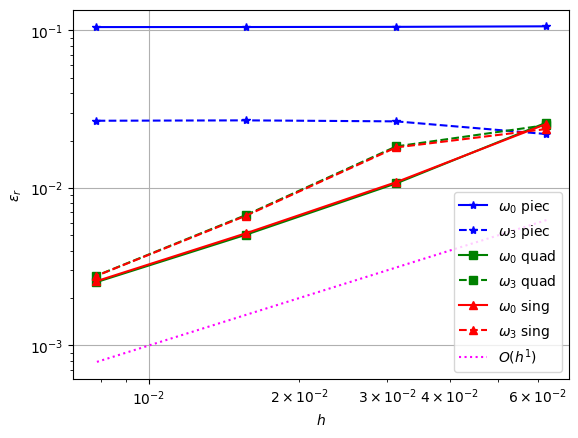

In [240]:
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
plt.plot(h_i, rel_error_piecewise[0], "*-", label='$\omega_0$ piec', color=colors_list[0])
plt.plot(h_i, rel_error_piecewise[1], "*--", label='$\omega_3$ piec', color=colors_list[0])
plt.plot(h_i, rel_error_quadratic[0], "s-", label='$\omega_0$ quad', color=colors_list[1])
plt.plot(h_i, rel_error_quadratic[1], "s--", label='$\omega_3$ quad', color=colors_list[1])
plt.plot(h_i, rel_error_singular[0], "^-", label='$\omega_0$ sing', color=colors_list[2])
plt.plot(h_i, rel_error_singular[1], "^--", label='$\omega_3$ sing', color=colors_list[2])
plt.plot(
    h_i,
    [1e-1*x**1 for x in h_i],
    linestyle="dotted",
    # marker="o",
    label=f"$O(h^{{{1}}})$",
    color= colors_list[3]
)
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$h$")
_ = plt.ylabel("$\epsilon_r$")
plt.legend()

In [241]:
# rel_error=eigvec_L2_error(approx_piecewise_eigvs_p[3][3], exact_p[3])
# rel_error

In [242]:
def get_function_plot_data(u):
    """
    Devolve (x_sorted, values_sorted) listos para plt.plot.

    Funciona en mallas 1D en dolfinx 0.9.
    Usa coordenadas dos DOFs do espazo de u.
    """

    V = u.function_space
    mesh = V.mesh

    # Coordenadas dos DOFs
    X = V.tabulate_dof_coordinates().copy()

    # COLAPSAR dimensións sobrantes: quedamos coa coordenada x
    if X.shape[1] > 1:
        X = X[:, 0]

    # Obter valores da función
    try:
        vals = u.x.array.copy()
    except AttributeError:
        vals = u.vector.getArray().copy()

    # Ordenar por coordenada x
    idx = np.argsort(X)
    return X[idx], vals[idx]


In [243]:
exact_eigv_p = {
0: get_exact_eigenpair(mesh[2], FE, 0, sigma_piecewise_py, x_hat_piecewise, gamma_x_piecewise)[1],
1: get_exact_eigenpair(mesh[2], FE, 1, sigma_piecewise_py, x_hat_piecewise, gamma_x_piecewise)[1],
2: get_exact_eigenpair(mesh[2], FE, 2, sigma_piecewise_py, x_hat_piecewise, gamma_x_piecewise)[1],
3: get_exact_eigenpair(mesh[2], FE, 3, sigma_piecewise_py, x_hat_piecewise, gamma_x_piecewise)[1],
4: get_exact_eigenpair(mesh[2], FE, 4, sigma_piecewise_py, x_hat_piecewise, gamma_x_piecewise)[1]
}

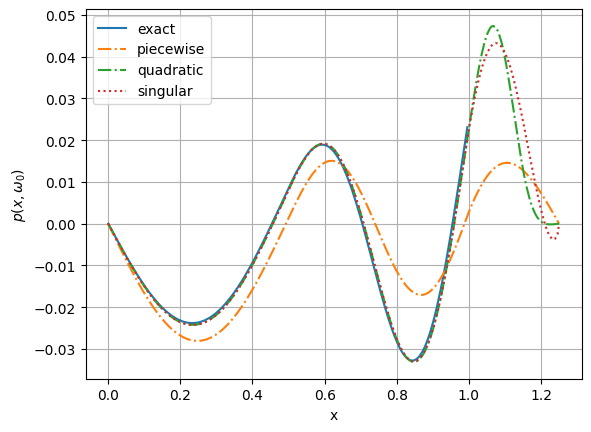

In [244]:
# Crear versión exacta proxectada á malla de u_num
u_ex_proj = project_exact_to_mesh(exact_eigv_p[1], approx_piecewise_eigvs_p[2][0].function_space)

# Datos
x_num_p, y_num_p = get_function_plot_data(approx_piecewise_eigvs_p[2][0])
x_num_q, y_num_q = get_function_plot_data(approx_quadratic_eigvs_p[2][0])
x_num_s, y_num_s = get_function_plot_data(approx_singular_eigvs_p[2][0])

x_ex , y_ex  = get_function_plot_data(u_ex_proj)
plt.plot(x_ex[x_ex<1] , np.real(y_ex[x_ex<1] ), label="exact", linestyle="solid")
plt.plot(x_num_p, np.real(y_num_p), label="piecewise", linestyle="-.")
plt.plot(x_num_q, np.real(y_num_q), label="quadratic", linestyle="-.")
plt.plot(x_num_s, np.real(y_num_s), label="singular", linestyle="dotted")

plt.xlabel("x")
plt.ylabel("$p(x, \omega_0)$")
plt.legend()
plt.grid(True)
plt.show()

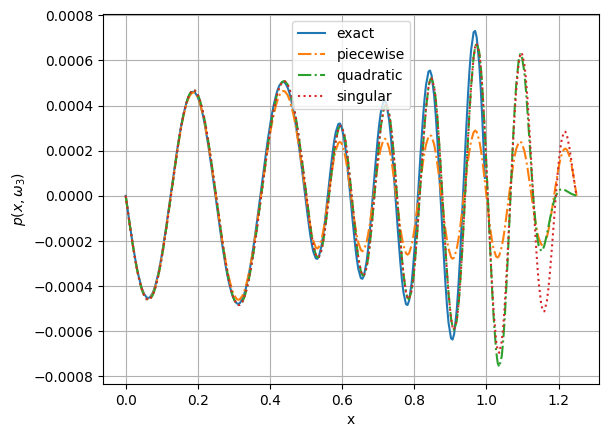

In [245]:
# Crear versión exacta proxectada á malla de u_num
u_ex_proj = project_exact_to_mesh(exact_eigv_p[4], approx_piecewise_eigvs_p[2][1].function_space)

# Datos
x_num_p, y_num_p = get_function_plot_data(approx_piecewise_eigvs_p[2][1])
x_num_q, y_num_q = get_function_plot_data(approx_quadratic_eigvs_p[2][1])
x_num_s, y_num_s = get_function_plot_data(approx_singular_eigvs_p[2][1])

x_ex , y_ex  = get_function_plot_data(u_ex_proj)
plt.plot(x_ex[x_ex<1] , np.real(y_ex[x_ex<1] ), label="exact", linestyle="solid")
plt.plot(x_num_p, np.real(y_num_p), label="piecewise", linestyle="-.")
plt.plot(x_num_q, np.real(y_num_q), label="quadratic", linestyle="-.")
plt.plot(x_num_s, np.real(y_num_s), label="singular", linestyle="dotted")

plt.xlabel("x")
plt.ylabel("$p(x, \omega_3)$")
plt.legend()
plt.grid(True)
plt.show()